In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define the path
parent_dir = Path.cwd().parent
data_dir = parent_dir / 'data'
input_dir = data_dir / 'cookie_cats.csv'

# Load the Dataset
df = pd.read_csv(input_dir)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
# Check the information about the Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### EDA

In [3]:
# Check the unique value of version, retention_1, retention_7
print(df['version'].value_counts(dropna=False))
print(df['retention_1'].value_counts(dropna=False))
print(df['retention_7'].value_counts(dropna=False))

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
retention_1
False    50036
True     40153
Name: count, dtype: int64
retention_7
False    73408
True     16781
Name: count, dtype: int64


`version`, `retention_1` and `retention_7` columns seem to be clean.

In [4]:
# Check the duplicated
df.duplicated().sum()

0

In [5]:
# Check whether there are the same IDs
df['userid'].duplicated().sum()

0

There are no duplicate values.

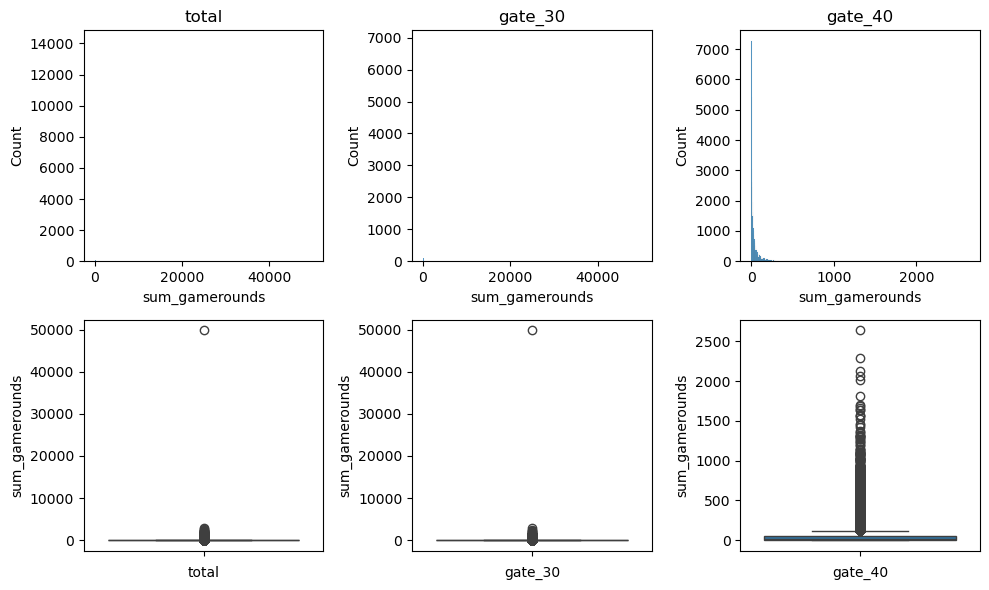

In [6]:
# Draw boxplots and histgrams of `sum_gamerounds` in the following 3 categories
# Entire dataset, gate_30 and gate_40 
# Create a grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# plot the graphs
for i, col in enumerate(['total', 'gate_30', 'gate_40']):
    if col == 'total':
        sns.histplot(data=df, x='sum_gamerounds', ax = axes[0, i])
        axes[0, i].set_title(f'{col}')
            
        sns.boxplot(data=df, y='sum_gamerounds', ax=axes[1, i])
        axes[1, i].set_xlabel(f'{col}')
    

    else:
        sns.histplot(data=df[df['version'] == col], x='sum_gamerounds', ax = axes[0, i])
        axes[0, i].set_title(f'{col}')
        
        sns.boxplot(data=df[df['version'] == col], y='sum_gamerounds', ax=axes[1, i])
        axes[1, i].set_xlabel(f'{col}')

plt.tight_layout()
plt.show()

    

It's hard to attain insights from this graph because extreme outliers stretch it. Therefore, I will apply log transformation.

In [7]:
# Create a copy of df
df_log = df.copy()

# Create a new column and apply log transformation
# Apply log(1+x) to handle zero values
df_log['log_sum_gamerounds'] = np.log1p(df_log['sum_gamerounds'])

# Check the transformation
df_log.describe()

,userid,sum_gamerounds,log_sum_gamerounds
count,9.018900e+04,90189.000000,90189.000000
mean,4.998412e+06,51.872457,2.879746
std,2.883286e+06,195.050858,1.503792
min,1.160000e+02,0.000000,0.000000
25%,2.512230e+06,5.000000,1.791759
50%,4.995815e+06,16.000000,2.833213
75%,7.496452e+06,51.000000,3.951244
max,9.999861e+06,49854.000000,10.816874


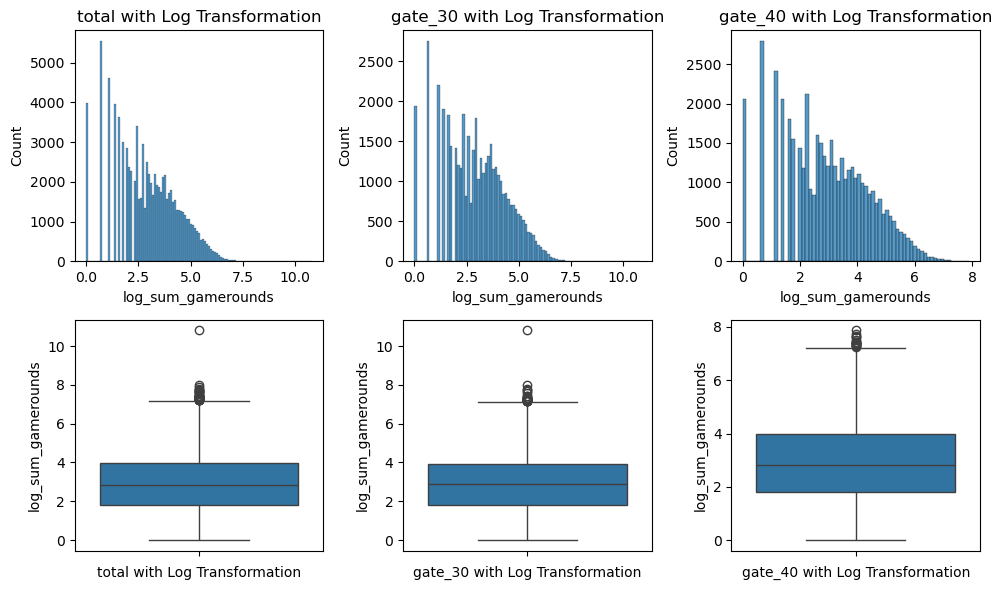

In [8]:
# Draw boxplots and histgrams of `sum_gamerounds` in the following 3 categories
# Entire dataset, gate_30 and gate_40 
# Create a grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# plot the graphs
for i, col in enumerate(['total', 'gate_30', 'gate_40']):
    if col == 'total':
        sns.histplot(data=df_log, x='log_sum_gamerounds', ax = axes[0, i])
        axes[0, i].set_title(f'{col} with Log Transformation')
            
        sns.boxplot(data=df_log, y='log_sum_gamerounds', ax=axes[1, i])
        axes[1, i].set_xlabel(f'{col} with Log Transformation')
    

    else:
        sns.histplot(data=df_log[df_log['version'] == col], x='log_sum_gamerounds', ax = axes[0, i])
        axes[0, i].set_title(f'{col} with Log Transformation')
        
        sns.boxplot(data=df_log[df_log['version'] == col], y='log_sum_gamerounds', ax=axes[1, i])
        axes[1, i].set_xlabel(f'{col} with Log Transformation')

plt.tight_layout()
plt.show()

The log-transformed visualization suggests that players in the **gate_40** group might have slightly higher gameplay counts compared to **gate_30**. However, it is not yet possible to determine whether this difference is **meaningful or statistically significant**, meaning it could simply be due to random variation and may not generalize to the overall player population.

In [9]:
# Check the retention rate in the entire dataset
retention_rate_total = df[['retention_1', 'retention_7']].mean()
retention_rate_total

retention_1    0.445210
retention_7    0.186065
dtype: float64

In [10]:
# Check the retention rate in gate_30 and gate_40
retention_rate_cat = df.groupby('version')[['retention_1', 'retention_7']].mean()
retention_rate_cat

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


The groupby results indicate that players in the **gate_30** group have slightly higher Day-1 and Day-7 retention rates compared to **gate_40**.

However, similar to the results from `sum_gamerounds`, it is not yet possible to determine whether this difference is **meaningful or statistically significant**, meaning it may simply be due to random chance rather than a real effect in the overall player population.

Therefore, I will perform statistical analysis to evaluate the impact of the gate placement on both retention and sum of game rounds.

### Statistical Analysis on `sum_gamerounds`
As observed in the EDA, the log-transformed visualization suggests that players in the **gate_40** group might have slightly higher gameplay counts compared to **gate_30**. However, it remains unclear whether these differences are **statistically significant**. To verify this, the following steps will be performed:
1. **Investigate Normality and Assumptions**

   Before choosing an appropriate statistical test, assess whether the distributions of `sum_gamerounds` are approximately normal and meet the necessary assumptions.

2. **Select and Conduct the Appropriate Statistical Test**

   Based on the results of the assumption check, select the proper test (parametric or non-parametric) and perform it to evaluate whether there is a significant difference in gameplay counts between the two groups.

3. **Quantify Practical Difference and Uncertainty**

   Regardless of statistical significance, evaluate the **practical relevance** of the observed difference by computing:

   - **Effect size** (standardized difference in means)
   - **95% Confidence Interval for the mean difference** (estimation precision)

4. **State the Conclusion**

   Summarize the findings and connect the results back to the business question – whether moving the gate affects player engagement.


1. **Investigate Normality and Assumptions**

Before performing any statistical test, it is essential to verify whether the data satisfy the assumptions required for valid inference.

First, I will investigate the **assumptions of the parametric t-test**, which compares the means of two groups

**Assumption of the t-test**
1. **Independence of observations**

   Each observation must be independent of the others, meaning that one player's result should not influence another's.
   - **Why this matters:**
   
     Independence ensures that the calculated mean difference and standard error are unbiased. Violating this assumption can lead to misleading results and incorrect significance levels.

2. **Normality of the data**

   The t-test relies on the sampling distributions of the mean being approximately normal. 
   - **Why this matters:** 
     
     When data are highly skewed or contain extreme outliers, the mean is no longer a good measure of central tendency, and the t-test statistic may not follow a true t-distribution. However, by the **Central Limit Theorem**, the t-test remains robust to non-normality, especially with large samples (n>30).

   - **Note**
     
     Even if all t-test assumptions are met and the results are statistically valid, the test may still be uninformative when distributions are highly skewed, since the mean would not represent the data well. 

3. **Homogeneity of variance**

     The traditional independent samples t-test assumes that both groups being compared have equal population variances. (homoscedasticity) This can be evaluated using Levene's test, which tests the null hypothesis that all group variances are equal. 

     However, Levene's test can be **sensitive in large samples** because statistical power increases with sample size. When a dataset is large, the test can detect even tiny differences in variance as statistically significant, which means differences that are mathematically real but practically negligible.

     Conversely, in small samples, Levene's test tends to have low statistical power, meaning it may **fail to detect genuine variance differences**. In addition, Levene's test assumes **normality**.

     In light of all this, it is difficult to prove that population variances are equal in both groups in practice. Therefore, I will prioritize **Welch's t-test**, which does not assume equal variances. 

**Independence of Observations**

As observed in the EDA, there are no duplicated user IDs, meaning that each player appears only once in the dataset and was randomly assigned to either `gate_30` or `gate_40`. Therefore, this assumption is reasonably met.

**Normality of The Data**

In [54]:
# Check the number of samples in each groups
print(f"The number of samples of gate_30 is {len(df[df['version'] == 'gate_30']['sum_gamerounds'])}")
print(f"The number of samples of gate_40 is {len(df[df['version'] == 'gate_40']['sum_gamerounds'])}")

The number of samples of gate_30 is 44700
The number of samples of gate_40 is 45489


Both groups contain more than 30 samples(`gate_30`:44,700, `gate_40`:45,489). According to **Central Limit Theorem (CLT)**, with sufficiently large sample sizes, the sampling distribution of the mean tends to be approximately normal, even if the underlying data are not. Therefore, **the normality assumption required for the t-test is reasonably satisfied.**

However, while the t-test may remain statistically valid under the CLT, it is important to note that if the original distributions are highly skewed, the **mean may not be a representative or informative measure of central tendency**, even if the results are statistically correct.

Therefore, I will investigate the normality of the distributions.

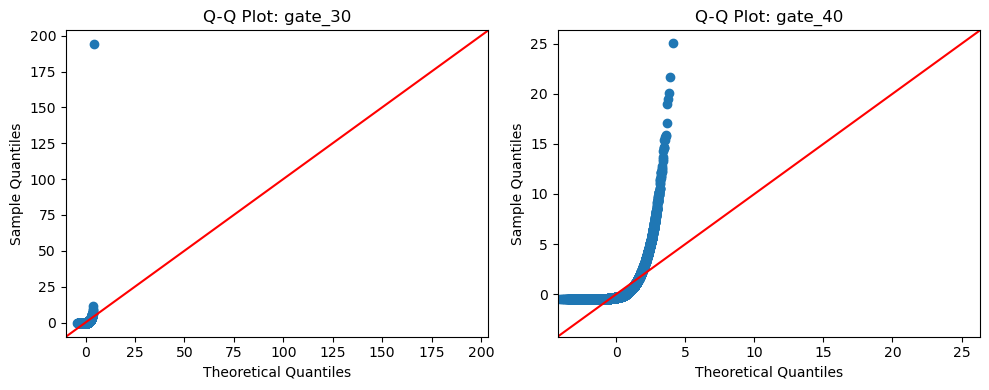

In [55]:
# Draw QQ plots of the distributions to check normality
# Import a necessary library
import statsmodels.api as sm
# Create a grid
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot QQ plots
for i, col in enumerate(['gate_30', 'gate_40']):
    # Scale the data to have the same magnitude as normal distribution
    x = df[df['version'] == col]['sum_gamerounds']
    x_scaled = (x - x.mean()) / x.std()

    sm.qqplot(x_scaled, line='45', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot: {col}')

plt.tight_layout()
plt.show()

In both groups, the sample quantiles (blue points) lie far from the theoretical normal line. This indicates that the distributions for both groups are not normal. I will investigate log-transformed version, just in case.

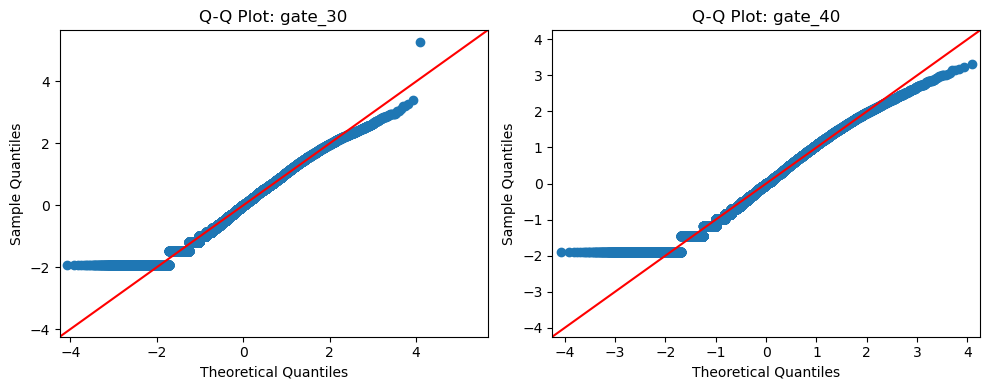

In [56]:
# Draw QQ plots of the distributions to check normality
# Use log transformed version 
# Create a grid
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot QQ plots
for i, col in enumerate(['gate_30', 'gate_40']):
    # Scale the data to have the same magnitude as normal distribution
    x = df_log[df_log['version'] == col]['log_sum_gamerounds']
    x_scaled = (x - x.mean()) / x.std()

    sm.qqplot(x_scaled, line='45', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot: {col}')

plt.tight_layout()
plt.show()

The log transformation definitely improved the normality, but the distributions still appear to be slightly right-skewed.

To confirm the distributions are not normal, I will investigate mean, median and skewness of the original and log-transformed distributions.

In [57]:
# Investigate mean, median and skewness of distributions
for col in ['gate_30', 'gate_40']:
    data = df[df['version'] == col]['sum_gamerounds']
    print(f'{col}')
    print(f'Mean: {data.mean():.3f}, Median: {data.median():.3f}, Skewness: {data.skew():.3f}\n')


gate_30
Mean: 52.456, Median: 17.000, Skewness: 163.710

gate_40
Mean: 51.299, Median: 16.000, Skewness: 5.967



The mean and median of both original distributions differ substantially, indicating asymmetry. Both distributions are also highly skewed.

**Rule of thumb of skewness:**
- Between -0.5 and + 0.5: fairly symmetrical
- Between -1 and -0.5 or +0.5 and 1 : moderately skewed
- Less than -1 or greater than +1: highly skewed

Since both `gate_30`(skewness=163.710) and `gate_40`(skewness=5.97) have skewness values far greater than 1, they are considered **highly positively skewed**.

In [58]:
# Investigate mean, median and skewness of log-transformed distributions
for col in ['gate_30', 'gate_40']:
    data = df_log[df_log['version'] == col]['log_sum_gamerounds']
    print(f'{col}')
    print(f'Mean: {data.mean():.3f}, Median: {data.median():.3f}, Skewness: {data.skew():.3f}\n')


gate_30
Mean: 2.889, Median: 2.890, Skewness: 0.099

gate_40
Mean: 2.871, Median: 2.833, Skewness: 0.110



The mean and median of both log-transformed distributions are very close, indicating near symmetry. Both distributions now show very low skewness after transformation.

** Rule of thumb of skewness:**
- Between -0.5 and + 0.5: fairly symmetrical
- Between -1 and -0.5 or +0.5 and 1 : moderately skewed
- Less than -1 or greater than +1: highly skewed

Since both `gate_30`(skewness=0.099) and `gate_40`(skewness=0.11) have skewness values greater than -0.5 and less than 0.5, they are considered **fairly symmetrical**.

In [59]:
# Investigate kurtosis of log-transformed distributions
for col in ['gate_30', 'gate_40']:
    data = df_log[df_log['version'] == col]['log_sum_gamerounds']
    print(f'{col}')
    print(f'kurtosis: {data.kurtosis():.3f}\n')

gate_30
kurtosis: -0.561

gate_40
kurtosis: -0.605



The kurtosis values of both log-transformed distributions are close to zero:
- `gate_30`: -0.561
- `gate_40`: -0.605

**Rule of thumb for kurtosis**:
- Between -1 and +1: approximately normal(mesokuric)
- Less than -1: flatter than normal(platykuric)
- Greater than +1: more peaked than normal(leptokuric)

Since both `gate:30` and `gate_40` have kurtosis values between -1 and +1, they are considered as approximately normal.

After investigating Q-Q plots, mean-median differences, skewness and kurtosis, it can be concluded that the **log-transformed distributions are approximately normal**, whereas the original distributions are highly positively skewed.

2. **Select and Conduct the Appropriate Statistical Test**

   As observed, the assumptions for **Welch's t-test** are satisfied, and the means of log-transformed distributions are representative measures of the data. Therefore, I will apply
   **Welch's t-test** to **log-transformed distributions** for the two groups.

In [60]:
# Split te data into two groups
gate_30_log = df_log[df_log['version'] == 'gate_30']['log_sum_gamerounds']
gate_40_log = df_log[df_log['version'] == 'gate_40']['log_sum_gamerounds']

In [61]:
# Obtain the mean of each group
gate_30_log_mean = gate_30_log.mean()
gate_40_log_mean = gate_40_log.mean()

print(f'mean of gate_30_log is {gate_30_log_mean}')
print(f'mean of gate_40_log is {gate_40_log_mean}')

mean of gate_30_log is 2.888910239659926
mean of gate_40_log is 2.8707416710384863


**Conduct Welch's t-test**

**Null hypothesis**: The mean log-transformed `sum_gamerounds` is the same for players in the `gate_30` group and the `gate_40` group.

**Alternative hypothesis**: The means differ.

If *p_value < 0.05*, reject the null hypothesis, indicating the group means are significantly different.


In [62]:
# Import the necessary libraries
from scipy import stats

# Implement Welch's t-test
t_stats_round, p_value_round = stats.ttest_ind(gate_30_log, gate_40_log,  equal_var= False, alternative='two-sided')

print(f'T-statistic: {t_stats_round:.4f}')
print(f'P-Value: {p_value_round:.4f}')


T-statistic: 1.8142
P-Value: 0.0696


The P-value is **0.0696 > 0.05**, indicating that there is **not enough evidence to reject the null hypothesis.** In other words, there is **no statistically significant difference** in the mean `sum_gamerounds` between the `gate_30` and `gate_40` groups based on the **log-transformed data**. 

This suggests that the observed difference in average game play is likely due to random variation rather than a true effect of gate placement.

3. **Quantify Practical Difference and Uncertainty**

**Evaluate Effect Size**

Now, I will evaluate the **effect size** to understand the magnitude of the difference between the two groups. Cohen's *d* is one of the most common effect size measures, but it assumes **equal variances** between groups. Since the assumption is often unrealistic and difficult to verify in practice, I will use **unequal-variance standardized mean difference** ($\delta'$) as described in [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC11562970/?utm_source=chatgpt.com#bibr3-00131644241278928).

To make the effect ($\delta'$) easier to interpret, I converted it into **the generalized unequal-variance version of Cohen's $U_3$**. Unlike the classical $U_3$, which assumes equal variances, the generalized $U_3$ adjusts for differences in spread and represents the **percentage of scores in the higher-mean group that are expected to exceed the mean of the lower-mean group**.

where:
$$
\delta' = \frac{\mu_B - \mu_A}{\sigma'}
$$

$$
\sigma' = \sqrt{w \sigma_A^2 + (1 - w)\sigma_B^2}, \quad 
w = \frac{n_A}{n_A + n_B}
$$

$$
\rho = \frac{\sigma_A}{\sigma_B}
$$

$$
U_3(\%) = 100 \times \Phi\!\left( \delta' \sqrt{\, w\rho^2 + (1 - w)} \right)
$$

Examples:
- **50%**: groups are essentially identical (no practical difference)
- **75%**: moderate difference
- **100%**: completely separated groups with no overlap

After computing ($\delta'$) from my data, I will calculate the corresponding generalized $U_3$ value to determine what percentage of the higher-mean group is above the mean of the lower-mean group, providing an intuitive and variance-robust interpretation of the effect size.


In [63]:
# Import a necessary library
# Note: numpy has been imported earlier in the notebook.
import math
from scipy.stats import norm

# Create a function to calculate effect size and U3
def effect_U3(data1, data2):
    # Validate the data
    # Convert the data to numpy array
    x = np.asarray(data1, dtype=float)
    y = np.asarray(data2, dtype=float)
    
    # Ensure each input is 1D
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError('Inputs must be 1-dimensional.')
    
    # Require at least 2 data points
    if len(x) < 2 or len(y) < 2:
        raise ValueError('Each input must contain at least 2 data points')
    
    # Reject NaN values
    if np.isnan(x).any() or np.isnan(y).any():
        raise ValueError('Inputs must not contain NaN values')

    # Compute mean, std and sample size
    m_b, m_a = x.mean(), y.mean()
    std_b, std_a = x.std(ddof=1), y.std(ddof=1)
    n_b, n_a = len(x), len(y)
   
    # Standard deviation must be non-zero
    if std_b == 0 or std_a == 0:
        raise ValueError('Standard deviations must be non-zero')

    # Change the order if m_b < m_a
    if m_b < m_a:
        m_b, m_a = m_a, m_b
        std_b, std_a = std_a, std_b
        n_b, n_a = n_a, n_b
    
    # Compute w
    w = n_a / (n_b + n_a)

    # Compute rho
    rho = std_a / std_b 

    # Compute sigma dash
    inside_sig = w * (std_a ** 2) + (1 - w) * (std_b ** 2) 
    sig = math.sqrt(inside_sig)

    # Compute effect size
    effect_size = (m_b - m_a) / sig

    # compute adjusted U3 %
    inside_scale = w * (rho ** 2) + (1 - w)
    scale = math.sqrt(inside_scale)
    Adj_effect_size =  effect_size * scale
    u3 = norm.cdf(Adj_effect_size, loc=0, scale=1) * 100

    return effect_size, u3

In [64]:
# Compute the effect size
effect, u= effect_U3(gate_30_log, gate_40_log)

# Print the results
print(f'The effect size is: {effect:.3f}')
print(f'Approximately {u:.2f}% gate_30_log is expected to exceed the mean of gate_40_log')


The effect size is: 0.012
Approximately 50.48% gate_30_log is expected to exceed the mean of gate_40_log


The effect size is extremely small (0.012), indicating no meaningful difference between the two groups.

The U3 index (≈50.48%) shows that the distributions are nearly indistinguishable, with approximately half of the values in `gate_30_log` exceeding the mean of `gate_40_log`. This aligns with the results of the preceding hypothesis test, which also found no statistically significant difference between the groups.

**Confidence Interval for Mean Difference** 
To complement the hypothesis test, a **95% confidence interval (CI)** for the mean difference between the two groups was computed. The CI provides an estimate of the **range of plausible true differences** in average gameplay counts between `gate_30_log` and `gate_40_log`.

The CI is calculated using **Welch's method**, which does not assume equal variances between groups. The formula used is:

$$
CI = (\bar{x}_1 - \bar{x}_2)
\pm t_{\alpha/2, df} \cdot
\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}
$$

$$
df =
\frac{
\left( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2
}{
\frac{s_1^4}{n_1^2(n_1-1)} +
\frac{s_2^4}{n_2^2(n_2-1)}
}
$$

**Assumptions**:
Welch's confidence interval relies on the following assumptions:
1. **Independence of observations**

   Each player's gameplay count is independent of others.

2. **Approximately normal distribution of variable**

   The log-transformed `sum_gamerounds` in each group is reasonably symmetric without extreme skew.

3. **No assumption of equal variances**

The two groups that we are investigating fulfill these assumptions. Therefore, I will implement CI in Welch's method.

In [65]:
# Import a necessary library
# Note: numpy and scipy.stats have been imported earlier in the notebook.
from statsmodels.stats.weightstats import ttest_ind as ttest_ind_welch    # To compute df


# Crete a function to compute confidence interval
def confidence_interval(data1, data2, interval):
    # Validate the data
    # Convert the data to numpy array
    x = np.asarray(data1, dtype=float)
    y = np.asarray(data2, dtype=float)
    
    # Ensure each input is 1D
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError('Inputs must be 1-dimensional.')
    
    # Require at least 2 data points
    if len(x) < 2 or len(y) < 2:
        raise ValueError('Each input must contain at least 2 data points')
    
    # Reject NaN values
    if np.isnan(x).any() or np.isnan(y).any():
        raise ValueError('Inputs must not contain NaN values')
    
    # Let group B = group with higher mean
    if x.mean() < y.mean():
        x, y = y, x
    
    # Compute statistics
    mean_diff = x.mean() - y.mean()
    s1 = x.std(ddof=1)  
    s2 = y.std(ddof=1) 
    se = np.sqrt(s1**2 / len(x) + s2**2 / len(y) ) 
    
    # Compute df
    tstat, pvalue, df = ttest_ind_welch(x, y, alternative= 'two-sided', usevar='unequal')

    # Critical value for 95% CI
    alpha = 1 - interval / 100
    t_crit = stats.t.ppf(1 - alpha/2, df)
    
    # Calculate CI
    ci_low = mean_diff - t_crit * se
    ci_high = mean_diff +  t_crit * se

    return ci_low, ci_high

In [82]:
# Compute 95% CI
low, high = confidence_interval(gate_30_log, gate_40_log, 95)

print(f'95% CI for the mean difference (higher - lower):[{low:.2f}, {high:.2f}]')

95% CI for the mean difference (higher - lower):[-0.00, 0.04]


4. **State the Conclusion**

Together, the hypothesis test, effect size, and confidence interval all point to the **same conclusion**:

- The Welch **t-test** shows that the difference in mean gameplay between the
`gate_30_log` and `gate_40_log` groups is **not statistically significant** (p = 0.0696 > 0.05).

- The **effect size** is extremely small (0.012), indicating **no meaningful practical difference** in behavior between the groups.

- The **generalized $U_3$** value (≈50.48%) shows that the distributions are nearly identical.

- The **95% confidence interval** for the mean difference (-0.00 to 0.04)  includes **zero**, reinforcing that we cannot rule out the possibility of **no
true difference** in the population.

**Overall**:
There is no statistical evidence that changing the gate from 30 to 40 has any measurable impact on player engagement based on log-transformed gameplay rounds.

This suggests that the observed differences are very likely due to **random noise**, not a real effect of gate placement.

**Statistical Analysis on Retention Rates**

As observed in the EDA, there are slightly higher retentions in `gate_30` than `gate_40`, but we test whether this difference is **statistically meaningful**.

1. **Assumption Check**

   Before choosing a test, I check two things:

- **Independence of Observations**

  Observations are independent due to random assignment.
- **Adequacy of Expected Cell COUNTS**

  Expected cell counts are sufficient for chi-square approximation
  (rule of thumb:  `np ≥ 5` and `n(1-p) ≥ 5`; [Kim, 2016](https://rde.ac/journal/view.php?number=711&utm_souorce=chatgpt.com))

2. **Select and Conduct the Appropriate Statistical Test**

   Based on the results of the assumption check, select the proper test:
   - If the assumptions hold: Use a **Chi-square test**
   - If they don't hold: Switch to **Fisher's Exact Test**

   Then, perform it to evaluate whether there is a significant difference in `retention_1` and `retention_7` between the two groups.

3. **Quantify Practical Difference and Uncertainty**

   Regardless of statistical significance, evaluate the **practical relevance** of the observed difference by computing:

   - **95% Confidence Interval for the proportion difference** 
   - **95% Confidence Interval for the odds ratio** [reference](https://pmc.ncbi.nlm.nih.gov/articles/PMC2938757/?utm_source=chatgpt.com)
  
4. **State the Conclusion**

   Summarize the findings and connect the results back to the business question – whether moving the gate affects player engagement.

1. **Assumption Check**

**Independence of Observations**

As observed in the EDA, there are no duplicated user IDs, meaning that each player appears only once in the dataset and was randomly assigned to either `gate_30` or `gate_40`. Therefore, this assumption is reasonably met.

**Adequacy of Expected Cell COUNTS**

In [67]:
# Create the contingency table for `retention_1`  to calculate expected cell counts
contingency_table_1 = pd.crosstab(df['version'], df['retention_1'])
contingency_table_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [68]:
# Create the contingency table for `retention_7`  to calculate expected cell counts
contingency_table_7 = pd.crosstab(df['version'], df['retention_7'])
contingency_table_7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [69]:
# Calculate expected cell counts fore `retention_1`
from scipy.stats import chi2_contingency
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)
expected_1 

array([[24799.13514952, 19900.86485048],
       [25236.86485048, 20252.13514952]])

In [70]:
# Calculate expected cell counts `retention_7`
chi2_7, p_7, dof_7, expected_7 = chi2_contingency(contingency_table_7)
expected_7

array([[36382.90257127,  8317.09742873],
       [37025.09742873,  8463.90257127]])

For both Day-1 and Day-7 retention  tables, all expected cell counts are far grater than 5. **This fully satisfies the assumptions for the chi-square test** is appropriate for assessing retention differences between the groups.

2. **Select and Conduct the Appropriate Statistical Test**

   Since the assumptions of the Chi-square test are satisfied for both retention metrics, Chi-square tests are used to evaluate differences in proportions between the two groups.

   **Hypotheses(for both Day-1 and Day-7 retention)**:

   **Null hypothesis**: The proportions are the same for players in the `gate_30` group and the `gate_40` group.

   **Alternative hypothesis**: The proportions differ.

   If *p_value < 0.05*, reject the null hypothesis, indicating the proportions are significantly different.


In [71]:
# Conduct the hypothesis test
print(f'The P value of Retention_1 {p_1:.3f}')
print(f'The P value of Retention_7 {p_7:.3f}')

The P value of Retention_1 0.076
The P value of Retention_7 0.002


The Chi-square test for Day-1 retention yields a p-value of **0.076(>0.05)**, meaning the early return behavior **does not differ significantly** between the two gate conditions.

However, the Day-7 retention test returns a p-value of **0.002(<0.05)**, indicating a **statistically significant** difference in longer-term retention.

3. **Quantify Practical Difference and Uncertainty**

In [72]:
# Check the sample proportion again
retention_rate_cat

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [73]:
# Calculate the sample proportion difference
retention_diff = retention_rate_cat.loc['gate_30'] - retention_rate_cat.loc['gate_40']
print('Difference in retention rates (gate_30 - gate_40)')
print(retention_diff)

Difference in retention rates (gate_30 - gate_40)
retention_1    0.005905
retention_7    0.008201
dtype: float64


In [74]:
# Check the table
contingency_table_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [75]:
# Check the table
contingency_table_7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [76]:
# Create a function to slice each count
def slice_counts(table):
    counts_1_t = table.loc['gate_30', True]
    counts_1_f = table.loc['gate_30', False]
    counts_2_t = table.loc['gate_40', True]
    counts_2_f = table.loc['gate_40', False]
    return counts_1_t,  counts_1_f, counts_2_t, counts_2_f 


In [77]:
# Create a function to calculate odds ratio CI 
def compute_odds_ratio_ci(counts_1_t, counts_1_f, counts_2_t, counts_2_f, interval):
    # Calculate estimated odds ratio
    est_or = (counts_1_t / counts_1_f) / (counts_2_t /  counts_2_f)
    
    # Critical value for 95% CI
    alpha = 1 - interval / 100
    z_crit = stats.norm.ppf(1 - alpha/2)


    or_low = math.exp(math.log(est_or) - z_crit * math.sqrt(1 / counts_1_t + 1 / counts_1_f + 1 / counts_2_t + 1 / counts_2_f) )
    or_high = math.exp(math.log(est_or) + z_crit * math.sqrt(1 / counts_1_t + 1 / counts_1_f + 1 / counts_2_t + 1 / counts_2_f))

    return est_or, or_low, or_high 

In [78]:
# Create a function to calculate proportion CI
# Import necessary library
from statsmodels.stats.proportion import confint_proportions_2indep

def compute_prop_diff_ci(counts_1_t, counts_1_f, counts_2_t, counts_2_f, interval):
    # Calculate the sample_size
    sample_size_1 = counts_1_t + counts_1_f
    sample_size_2 = counts_2_t + counts_2_f

    # Calculate alpha
    alpha = 1 - interval /100

    ci_low, ci_high = confint_proportions_2indep(counts_1_t, sample_size_1, counts_2_t,  sample_size_2, compare='diff', alpha=alpha)

    return ci_low, ci_high

In [79]:
# Combine the functions
def proportion_analysis(table, interval):
    # Slice each count
    counts_1_t,  counts_1_f, counts_2_t, counts_2_f = slice_counts(table)

    # Calculate odd's ratio CI
    est_or, or_low, or_high = compute_odds_ratio_ci(counts_1_t,  counts_1_f, counts_2_t, counts_2_f, interval)

    # Calculate proportion CI
    ci_low, ci_high = compute_prop_diff_ci(counts_1_t,  counts_1_f, counts_2_t, counts_2_f, interval)

    return  est_or, or_low, or_high,  ci_low, ci_high

In [81]:
# Compute odds ratio CI and proportion CI
est_or_1, or_low_1, or_high_1,  ci_low_1, ci_high_1 = proportion_analysis(contingency_table_1, 95)
est_or_7, or_low_7, or_high_7,  ci_low_7, ci_high_7 = proportion_analysis(contingency_table_7, 95)

# Print the results
print('Analysis of retention_1\n')
print('--------------------------')
print(f'Estimated odds ratio of retention_1 is {est_or_1:.2f}')
print(f'95% Odds ratio CI for retention_1 is :[{or_low_1:.2f}, {or_high_1:.2f}]')
print(f'95% CI for the proportion difference for retention_1 is (gate_30 - gate_40):[{ci_low_1:.2f}, {ci_high_1:.2f}]\n')


print('Analysis of retention_7\n')
print('--------------------------')
print(f'Estimated odds ratio of retention_7 is {est_or_7:.2f}')
print(f'95% Odds ratio CI for retention_7 is :[{or_low_7:.2f}, {or_high_7:.2f}]')
print(f'95% CI for the proportion difference for retention_7 is (gate_30 - gate_40):[{ci_low_7:.2f}, {ci_high_7:.2f}]')

Analysis of retention_1

--------------------------
Estimated odds ratio of retention_1 is 1.02
95% Odds ratio CI for retention_1 is :[1.00, 1.05]
95% CI for the proportion difference for retention_1 is (gate_30 - gate_40):[-0.00, 0.01]

Analysis of retention_7

--------------------------
Estimated odds ratio of retention_7 is 1.06
95% Odds ratio CI for retention_7 is :[1.02, 1.09]
95% CI for the proportion difference for retention_7 is (gate_30 - gate_40):[0.00, 0.01]


**Interpretation**

**Retention Day 1**

-**Odds Ratio**
 - Users in **gate_30** have **2% higher** odds of returning on day 1 compared to **gate_40**. (**1.02**)
 - However, since the CI includes **1.00**, the difference may be **too small to be practically meaningful.** (**[1.00, 1.05]**)

-**95% CI for the difference proportions:** 
 - The proportion difference between groups is extremely small, indicating **almost identical retention**. **[-0.00, 0.01]**

**Retention Day 7**

-**Odds Ratio**
 - Users in **gate_30** have **6% higher** odds of returning on day 7 compared to **gate_40**. (**1.06**)
 - However, since the CI does not include **1.00**, **which means statistically meaningful**, though still **modest** in magnitude. (**[1.02, 1.09]**)

-**95% CI for the difference proportions:** 
 - The proportion difference between groups remains very small, indicating **nearly identical retention**. **[0.00, 0.01]**

4. **State the Conclusion**
gate_30 users show **slightly higher retention** than gate_40 users:

- **Day-1 Retention**:

  The difference in return behavior is **not statistically significant**. (p = 0.076)

  Effect size and proportion difference indicate **no meaningful practical difference**.

- **Day-7 Retention**:
 
  A **statistically significant**, but small improvement is seen in gate_30. (p = 0.002)

  Odds ratio suggests **≈6% higher odds**, though proportion difference indicates nearly identical retention.

- **Conclusion**

  **gate_30 offers a slight advantage in longer-term retention**, but the effect is **small**, so this change alone may **not justify major product decisions** without additional supporting evidence.
  

**Overall Summary & Conclusion**
Across both retention and gameplay engagement metrics, moving the gate from level 30 to level 40 shows **no meaningful improvement** in player behavior.
- **Day-1** retention: No statistically or practically significant difference
- **Day-7** retention: A **small** but statistically significant lift for gate_30 (≈6% higher odds of return, but only ~0 to 1 percentage point difference)
- **Gameplay rounds**: No significant difference and **negligible** effect size

**Gate_30 performs slightly better overall**, but the differences are very small and are unlikely to create a noticeable business impact.

Therefore, a gate change alone is **not supported by the data** as a lever to improve retention or engagement.

Future improvements should investigate **other game features or player experience factors** to drive measurable gains.